# Raster Scan

# General Imports

In [1]:
%config IPCompleter.greedy=True

# import matplotlib.pyplot as plt
import numpy as np
import time
import zhinst.core
import laboneq
from laboneq.simple import *
import ctypes
import helpers
import matplotlib.pyplot as plt
from picosdk.ps5000a import ps5000a as ps
from picosdk.functions import adc2mV, assert_pico_ok, mV2adc
import picoscope_module as pm
import time
import zhinst.core
#install_token("LabOneQ.AllQuantumInOne.")
DO_EMULATION = False # run in emulation mode by default

print(laboneq.__version__)

2.11.0


# Sampling card setup

## Device Setup

Picoscope and HDAWG

In [2]:
timebase = 900
pico_sampling_rate = (timebase - 3) / 62500000
preTriggerSamples = 0
postTriggerSamples = int(50e-3/pico_sampling_rate)
print(postTriggerSamples)
TriggerLevel=1

maxSamples = preTriggerSamples + postTriggerSamples
ready = ctypes.c_int16(0)
check = ctypes.c_int16(0)
maxADC = ctypes.c_int16()

chandle, status = pm.initialize_picoscope()
chARange, chBRange, status = pm.setup_channels(chandle)
# find maximum ADC count value

pm.setup_trigger(chandle, chARange, chBRange, maxADC,TriggerLevel)

# Get timebase information

3483


{'maximumValue': 0,
 'setTriggerChannelPropertiesV2': 0,
 'setTriggerChannelConditionsV2': 0,
 'setTriggerChannelDirections': 0}

## Create device setup -HDAWG

In [3]:
descriptor="""
instrument_list:
  HDAWG:
  - address: DEV8721
    uid: device_hdawg
    interface: usb
connections:
  device_hdawg:
    - rf_signal: q0/fg8_line
      ports: [SIGOUTS/0]
    - rf_signal: q0/fg9_line
      ports: [SIGOUTS/1]
"""
#Change back to to SIGOUTS/2 and SIGOUTS/3
#And change fg8 and fg9
device_setup = DeviceSetup.from_descriptor(
    descriptor,
    server_host="127.0.0.1",
    server_port="8004",
    setup_name="ZI_HDAWG",
)

c:\Users\B15measure2\anaconda3\envs\laboneq\lib\site-packages\laboneq\dsl\device\_device_setup_generator.py:1104: FutureWarning: 'instrument_list' section is deprecated in setup descriptor, use 'instruments' instead.
  warnings.warn(


## Define parameters for experiment

In [4]:
START = -0.1
STOP = 0.1
STEPS = 8 #was 50 

## define length sweep parameter
level_sweep_parameter = LinearSweepParameter(
    uid="gate2_sweep", start=START, stop=STOP, count=STEPS,
)

In [5]:
# Hack
sampling_index = 13 # sampling rate is 2.4GHz/2^13, which is the minumium sampling rate HDAWG can go
# Log sequence recorded on 2023/07/27 1:23:01
daq = zhinst.core.ziDAQServer('127.0.0.1', 8004, 6) # Connect to awg with zhinst driver
daq.setInt('/dev8721/awgs/0/time', sampling_index)


sampling_rate= 1/2**sampling_index

times_map = {'pulse_time': 50e-3,
             'trigger_time': 1e-3} # The time Need to be larger than the 

for key in times_map:
    times_map[key] /= 2**sampling_index

# for key in times_map:
#     times_map[key] /= 2**sampling_index

print(times_map)

{'pulse_time': 6.103515625e-06, 'trigger_time': 1.220703125e-07}


In [6]:
# define pulse shapes
@pulse_library.register_pulse_functional
def ramp(x,start=0,stop=1 , **_):
    pulse=start+ (stop-start)*(x+1)/2 # Time normalized to (-1,1)
    return pulse



level_pulse = pulse_library.const(uid="step_level",length=times_map['pulse_time'],amplitude=1)
ramp_pulse = ramp(uid="ramp",start=-0.1,stop=0.1,length=times_map['pulse_time'])


In [7]:
## Create Experiment
exp = Experiment(
    "Singlet-triplet qubit example",
    signals=[
        ExperimentSignal("gate3"),
        ExperimentSignal("gate4"),
    ],
)

# define experiment
NUM_REP = 1

with exp.acquire_loop_rt(
    uid=("shots"), count=NUM_REP, averaging_mode=AveragingMode.SEQUENTIAL
):
    with exp.sweep(uid='sweep_rabi',parameter=level_sweep_parameter):
        with exp.section(
            uid="between_trigger", 
            length=times_map['trigger_time'],
            alignment=SectionAlignment.LEFT):
            exp.reserve(signal="gate3")
        with exp.section(
            uid=("level1"),
            length=times_map['pulse_time'], 
            trigger={"gate3": {"state": 1}},
            alignment=SectionAlignment.LEFT,
        ):
            exp.play(signal="gate3", pulse=ramp_pulse)
            exp.play(signal="gate4", pulse=level_pulse, amplitude = level_sweep_parameter)    

In [8]:
# shortcut to the logical signal group q0
lsg = device_setup.logical_signal_groups["q0"].logical_signals

# define signal map
map_signals = {
    "gate3" : lsg["fg8_line"],
    "gate4" : lsg["fg9_line"]
}

In [9]:
source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_B"] #set the buffer
noOfCaptures = NUM_REP*STEPS
status,timeIntervalns = pm.capture_rapid_data_block(chandle, preTriggerSamples, postTriggerSamples, timebase, maxSamples,noOfCaptures)


# # create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=DO_EMULATION)
# set experiment calibration and signal map
exp.set_signal_map(map_signals)



if not session.connection_state.emulated:
    instrument_serial = device_setup.instrument_by_uid("device_hdawg").address
    device = session.devices[instrument_serial]
    device.triggers.out[2].delay(23.9e-9)
print("Loaded exp")
session.run(exp)
print("Running exp finished")
# Check for data collection to finish using ps5000aIsReady
while ready.value == check.value:
    status["isReady"] = ps.ps5000aIsReady(chandle, ctypes.byref(ready))

buffersMax, buffersMin = pm.create_rapid_buffer(chandle, source, maxSamples, noOfCaptures)
pm.getValuesRapid(chandle,maxSamples,noOfCaptures)

2023.08.08 10:12:31.418 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\B15measure2\HDAWG\laboneq_output\log
2023.08.08 10:12:31.423 laboneq.controller.controller  INFO   VERSION: laboneq 2.11.0
2023.08.08 10:12:31.429 laboneq.controller.devices.device_collection INFO   Connecting to data server at 127.0.0.1:8004
2023.08.08 10:12:31.683 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.02 at 127.0.0.1:8004
2023.08.08 10:12:31.929 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.08.08 10:12:32.125 laboneq.controller.devices.device_collection INFO   The device setup is configured
Loaded exp
2023.08.08 10:12:32.374 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.08.08 10:12:32.579 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.08.08 10:12:32.634 labo

{'GetValuesBulk': 0}

In [13]:
print(np.vstack([voltage_in_mV, adc2mV(buffersMax[i], chBRange, maxADC)]))
print(voltage_in_mV)

[[5000. 5000. 5000. ... 5000. 5000. 5000.]
 [5000. 5000. 5000. ... 5000. 5000. 5000.]
 [5000. 5000. 5000. ... 5000. 5000. 5000.]
 ...
 [5000. 5000. 5000. ... 5000. 5000. 5000.]
 [5000. 5000. 5000. ... 5000. 5000. 5000.]
 [5000. 5000. 5000. ... 5000. 5000. 5000.]]
[[5000. 5000. 5000. ... 5000. 5000. 5000.]
 [5000. 5000. 5000. ... 5000. 5000. 5000.]
 [5000. 5000. 5000. ... 5000. 5000. 5000.]
 ...
 [5000. 5000. 5000. ... 5000. 5000. 5000.]
 [5000. 5000. 5000. ... 5000. 5000. 5000.]
 [5000. 5000. 5000. ... 5000. 5000. 5000.]]


In [11]:
# convert ADC counts data to mV
cmaxSamples = ctypes.c_int32(maxSamples)

# Create time data
time_stamp=int(time.time())
time_array = np.linspace(0, (cmaxSamples.value - 1) * timeIntervalns.value, cmaxSamples.value)
voltage_in_mV=[]
with open('Data/RasterScan_%s.npy'%(time_stamp), 'wb') as f:
    for i in range(noOfCaptures):
        # plot data from channel A and B
        if i == 0:
            voltage_in_mV = adc2mV(buffersMax[i], chBRange, maxADC)
        else:
            voltage_in_mV=np.vstack([voltage_in_mV, adc2mV(buffersMax[i], chBRange, maxADC)])


        # plt.plot(time, )
    # plt.xlabel('Time (ns)')
    # plt.ylabel('Voltage (mV)')
    # plt.show()
    # np.save(f,adc2mV(buffersMax[i], chARange, maxADC))
    np.save(f,voltage_in_mV)

 

# display status returns
# print(status)

# Stop the scope
status["stop"] = ps.ps5000aStop(chandle)
assert_pico_ok(status["stop"])


# # Close unit Disconnect the scope
# status["close"]=ps.ps5000aCloseUnit(chandle)
# assert_pico_ok(status["close"])

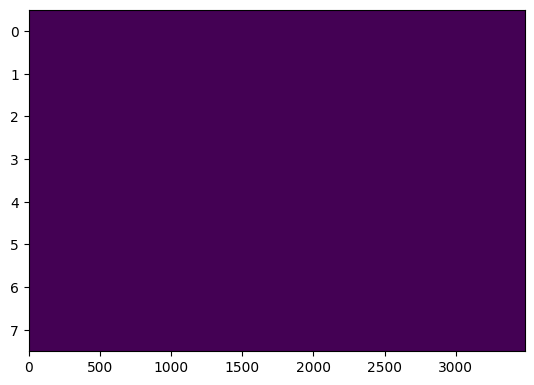

In [12]:
# print(voltage_in_mV)
# plt.figure(dpi=500)

plt.imshow(voltage_in_mV,aspect=300)

In [1]:
with open('test2.npy', 'rb') as f:
    # plt.imshow(np.load(f))
    plt.plot(np.load(f)[0,:])

NameError: name 'plt' is not defined

### View experiment in pulse sheet viewer

To-do: 
1. Add stability diagram visualization

In [13]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
compiled_exp = session.compiled_experiment
show_pulse_sheet(".\laboneq_output\ST pulse test", compiled_exp)

2023.07.29 22:46:44.042 laboneq.pulse_sheet_viewer.pulse_sheet_viewer INFO   Writing html file to c:\Users\B15measure2\HDAWG\laboneq_output\ST pulse test_2023-07-29-22-46-43.html


c:\Users\B15measure2\HDAWG\laboneq_output\ST pulse test_2023-07-29-22-46-43.html

In [11]:
helpers.interactive_psv(compiled_exp)

# 2D sweep example, wait time vs phase of second pulse

## Experiment

In [ ]:
## constant definition
X90_DURATION = 10e-9  # [s]

START = 0
STOP = 2 * np.pi
STEPS = 5
NUM_REP = 2

START_DELAY = 0
STOP_DELAY = LEN_COULOMB_CYCLE / 2 - 2 * X90_DURATION
STEPS_DELAY = 3


In [ ]:
## define phase sweep parameter
sweep_phase = LinearSweepParameter(
    uid="phase_sweep", start=START, stop=STOP, count=STEPS
)
sweep_delay = LinearSweepParameter(
    uid="Ramsey_delay", start=START_DELAY, stop=STOP_DELAY, count=STEPS_DELAY
)

print(sweep_phase.values / np.pi)

In [ ]:
## Create Experiment
exp = Experiment(
    "Ramsey variant I",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("gate1"),
        ExperimentSignal("gate2"),
    ],
)

# define experiment
with exp.acquire_loop_rt(
    uid="shots", count=NUM_REP, averaging_mode=AveragingMode.CYCLIC
):
    with exp.sweep(uid="sweep_delay", parameter=sweep_delay):
        with exp.sweep(uid="sweep_phase", parameter=sweep_phase):
            with exp.section(
                uid="qubit_excitation",
                alignment=SectionAlignment.RIGHT,
                length=LEN_COULOMB_CYCLE,
            ):
                exp.play(signal="gate1", pulse=coulomb_pulse, amplitude=0.5)
                exp.play(signal="gate1", pulse=coulomb_pulse, amplitude=0.75)

                exp.play(signal="gate2", pulse=coulomb_pulse, amplitude=0.5)
                exp.play(signal="gate2", pulse=coulomb_pulse, amplitude=0.75)

                exp.play(signal="drive", pulse=drive_pulse, set_oscillator_phase=0)
                exp.delay(signal="drive", time=sweep_delay)
                exp.play(
                    signal="drive",
                    pulse=drive_pulse,
                    increment_oscillator_phase=sweep_phase,
                )
            with exp.section(
                uid="qubit_readout",
                alignment=SectionAlignment.RIGHT,
                length=LEN_READOUT,
            ):
                exp.play(signal="gate1", pulse=coulomb_readout, amplitude=0.3)
                exp.play(signal="gate2", pulse=coulomb_readout, amplitude=0.3)
            with exp.section(
                uid="outer_trigger",
                length=LEN_READOUT,
                trigger={"drive": {"state": 1}},
                alignment=SectionAlignment.RIGHT,
            ):
                with exp.section(
                    uid="inner_trigger",
                    length=LEN_READOUT - 100e-9,
                    trigger={"drive": {"state": 2}},
                ):
                    exp.reserve(signal="drive")


In [ ]:
# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=DO_EMULATION)

# set experiment calibration and signal map
exp.set_calibration(calib_q0)
exp.set_signal_map(map_q0)

session.run(exp)

## View experiment in pulse sheet viewer

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
compiled_exp = session.compiled_experiment
show_pulse_sheet("2D example", compiled_exp)

